In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Defining functions we will be using for our reports later

In [2]:
from sklearn.metrics import roc_auc_score
def scores(model,X_train,X_val,y_train,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    print('train:',round(train,2),'test:',round(val,2))

In [3]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %50 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

In [4]:
from sklearn.metrics import roc_curve
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [5]:
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params,opt[cols]],axis=1,sort=False)
    
    plt.figure(figsize=[15,4])
    plt.subplot(121)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_train_score')*100)
    plt.title('ROC_AUC - Training')
    plt.subplot(122)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')
#     return opt

### Data preparation

In [6]:
food = pd.read_csv('foodinfo.csv')
food.shape

(228844, 10)

In [7]:
food.head()

,product_name,additives_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,nutrition-score-uk_100g
0,Banana Chips Sweetened (Whole),0.0,2243.0,28.57,28.57,64.29,14.29,3.57,0.00000,14.0
1,Peanuts,0.0,1941.0,17.86,0.00,60.71,17.86,17.86,0.63500,0.0
2,Organic Salted Nut Mix,0.0,2540.0,57.14,5.36,17.86,3.57,17.86,1.22428,12.0
3,Organic Muesli,1.0,1833.0,18.75,4.69,57.81,15.62,14.06,0.13970,7.0
4,Zen Party Mix,0.0,2230.0,36.67,5.00,36.67,3.33,16.67,1.60782,12.0


In [8]:
target = 'nutrition-score-uk_100g'
food['good'] = np.where(food[target]>=8,1,0)

X = food.drop([target,'good'],axis=1)
X = X.iloc[:,-2:]
y = food['good']

y.value_counts()

1    124122
0    104722
Name: good, dtype: int64

In [9]:
X.head()

,proteins_100g,salt_100g
0,3.57,0.00000
1,17.86,0.63500
2,17.86,1.22428
3,14.06,0.13970
4,16.67,1.60782


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=.2,random_state=42)

# Modelling

## Decision Trees

In [14]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

train: 0.95 test: 0.81


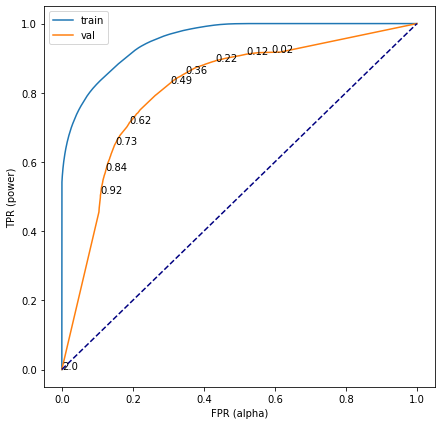

In [15]:
scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

The ROC curve shows signs of overfitting<br>
We want to try some hyperparameter optimisation to reduce the discrepancy between train and validation

### Grid Search CV with Decision Trees

In [16]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=42)

train: 0.9 test: 0.84
{'max_depth': 20, 'min_samples_leaf': 5}
CPU times: user 687 ms, sys: 136 ms, total: 823 ms
Wall time: 3.45 s


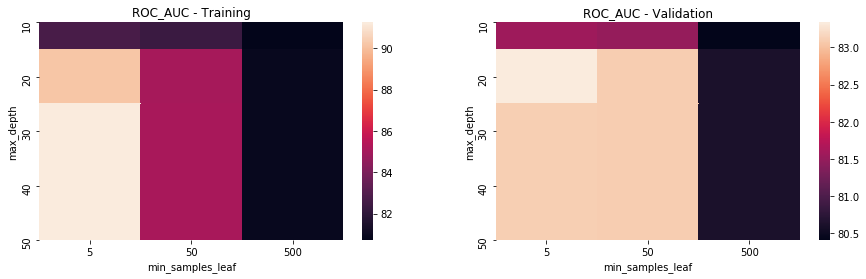

In [23]:
%%time
param_grid = {'max_depth':range(10,50+1,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.9 test: 0.84


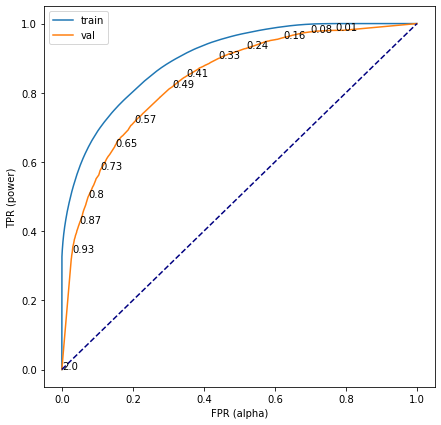

In [24]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.89 test: 0.84
{'max_depth': 20, 'min_samples_leaf': 10}
CPU times: user 1.99 s, sys: 553 ms, total: 2.54 s
Wall time: 15.7 s


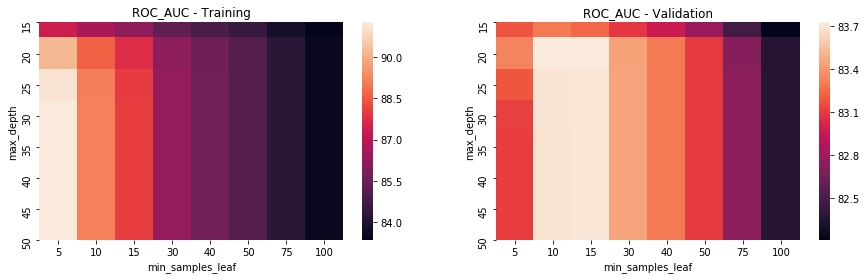

In [25]:
%%time
param_grid = {'max_depth':range(15,50+1,5),'min_samples_leaf':[5,10,15,30,40,50,75,100]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.89 test: 0.84


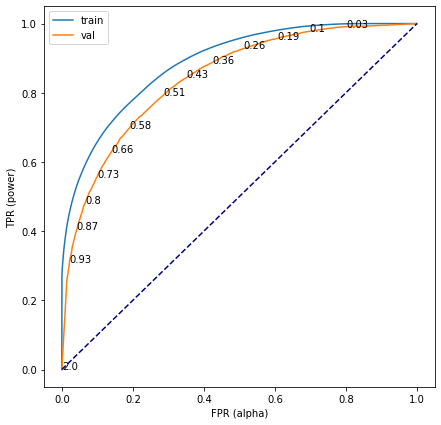

In [26]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.89 test: 0.84
{'max_depth': 23, 'min_samples_leaf': 12}
CPU times: user 7.36 s, sys: 2.27 s, total: 9.64 s
Wall time: 1min 8s


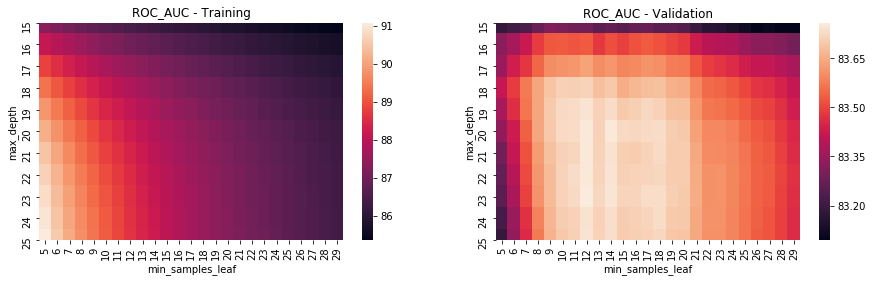

In [27]:
%%time
param_grid = {'max_depth':range(15,25+1),'min_samples_leaf':range(5,30)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.89 test: 0.84


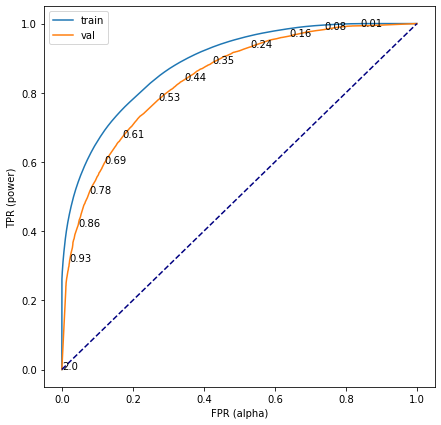

In [28]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

In [29]:
best_tree = best_model

## Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10,n_jobs=-1,random_state=42)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

train: 0.94 test: 0.85


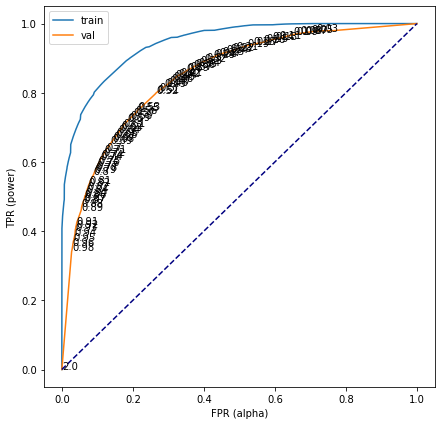

In [31]:
# Even off-the-shelf is better!!
scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

The ROC curve shows signs of overfitting<br>
We want to try some hyperparameter optimisation to reduce the discrepancy between train and validation

### Grid Search CV with Random Forest

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   11.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   12.5s finished


train: 0.9 test: 0.86
{'max_depth': 31, 'min_samples_leaf': 5}
CPU times: user 3.47 s, sys: 425 ms, total: 3.9 s
Wall time: 13.2 s


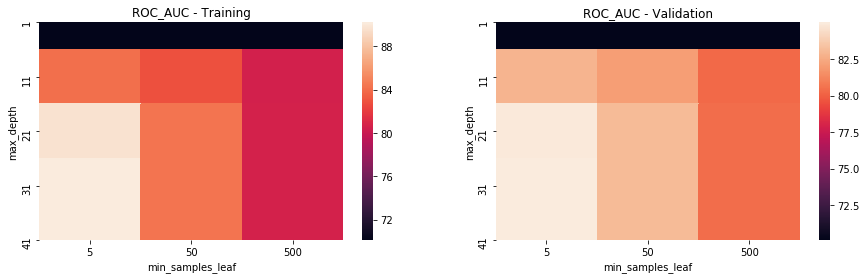

In [32]:
%%time
param_grid = {'max_depth':range(1,50+1,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1,verbose=10)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.9 test: 0.86


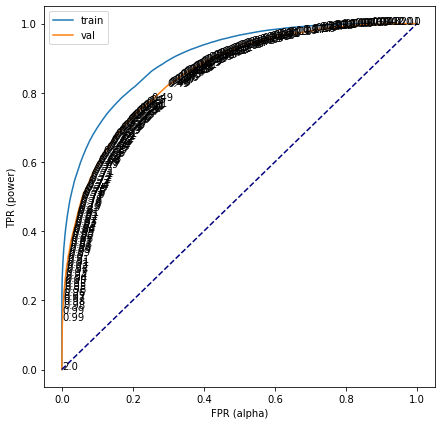

In [33]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.9 test: 0.85
{'max_depth': 30, 'min_samples_leaf': 5}
CPU times: user 5.03 s, sys: 807 ms, total: 5.84 s
Wall time: 1min 9s


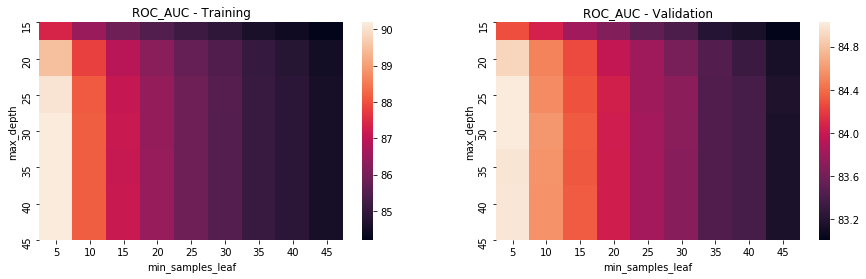

In [34]:
%%time
param_grid = {'max_depth':range(15,45+1,5),'min_samples_leaf':range(5,45+1,5)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.9 test: 0.85


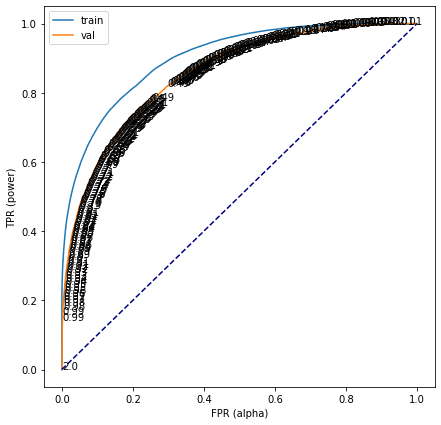

In [35]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.91 test: 0.86
{'max_depth': 20, 'min_samples_leaf': 2}
CPU times: user 9.09 s, sys: 2.05 s, total: 11.1 s
Wall time: 4min 19s


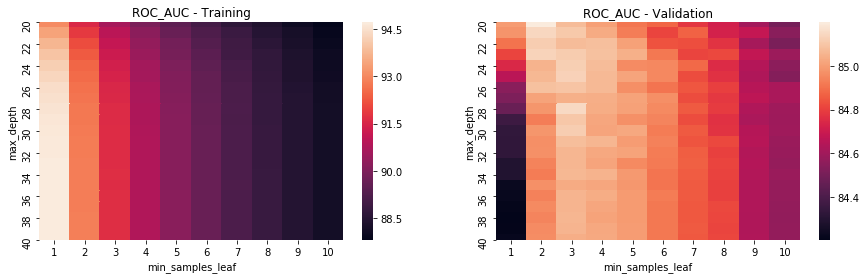

In [36]:
%%time
param_grid = {'max_depth':range(20,40+1,1),'min_samples_leaf':range(1,10+1)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.91 test: 0.86


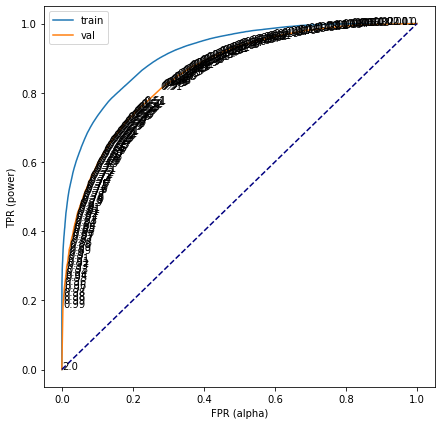

In [37]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.91 test: 0.86
{'max_depth': 20, 'min_samples_leaf': 2}
CPU times: user 4.9 s, sys: 806 ms, total: 5.71 s
Wall time: 1min 17s


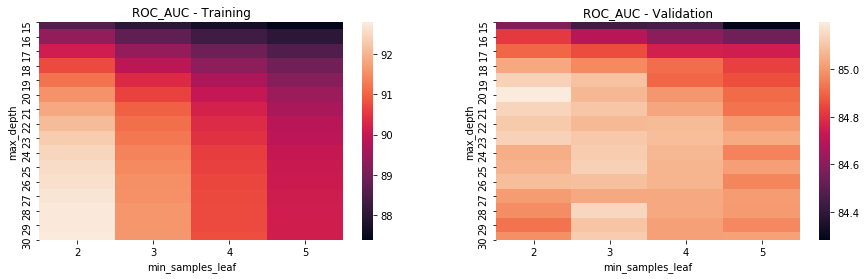

In [38]:
%%time
param_grid = {'max_depth':range(15,30+1),'min_samples_leaf':range(2,5+1)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.91 test: 0.86


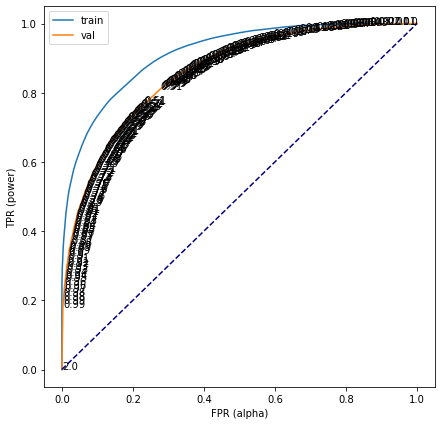

In [39]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

In [40]:
best_forest = best_model

## AdaBoost

In [56]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(DecisionTreeClassifier(),random_state=42)
model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                          

train: 0.95 test: 0.83


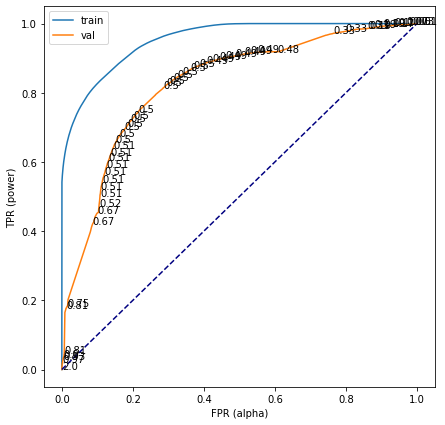

In [57]:
scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

### Grid Search CV with AdaBoost

In [58]:
param_grid = {'learning_rate':[lr/100 for lr in range(1,100+1)]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
# opt_plots(opt_model)

train: 0.95 test: 0.82
{'learning_rate': 0.94}


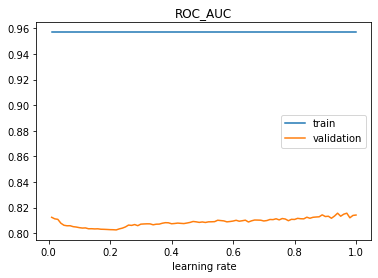

In [59]:
opt = pd.DataFrame(opt_model.cv_results_)
cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
params = pd.DataFrame(list(opt.params))
opt = pd.concat([params,opt[cols]],axis=1,sort=False)
plt.plot(opt['learning_rate'],opt['mean_train_score'])
plt.plot(opt['learning_rate'],opt['mean_test_score'])
plt.title('ROC_AUC')
plt.xlabel('learning rate')
plt.legend(['train','validation'])

In [49]:
param_grid = {'learning_rate':[lr for lr in range(1,10+1)]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
# opt_plots(opt_model)

train: 0.78 test: 0.77
{'learning_rate': 1}


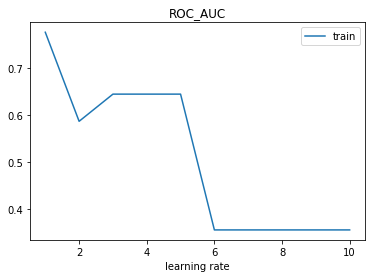

In [51]:
opt = pd.DataFrame(opt_model.cv_results_)
cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
params = pd.DataFrame(list(opt.params))
opt = pd.concat([params,opt[cols]],axis=1,sort=False)
plt.plot(opt['learning_rate'],opt['mean_train_score'])
plt.plot(opt['learning_rate'],opt['mean_test_score'])
plt.title('ROC_AUC')
plt.xlabel('learning rate')
plt.legend(['train','validation'])

train: 0.78 test: 0.77


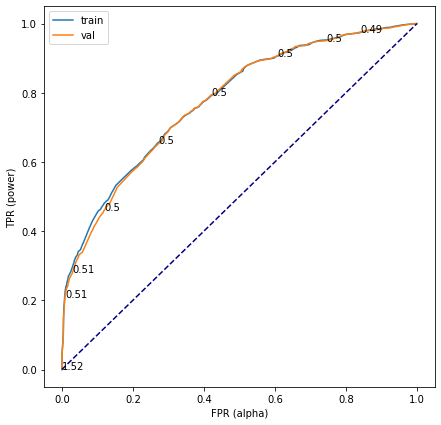

In [52]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

In [53]:
best_adaboost = best_model

In [ ]:
scores(best_model,X_val,X_test,y_train,y_test)

# Feature importances

In [ ]:
best_tree.feature_importances_

In [62]:
best_tree.feature_importances_

array([0.41999651, 0.58000349])

In [60]:
best_adaboost.estimator_weights_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Tree plotting

//anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


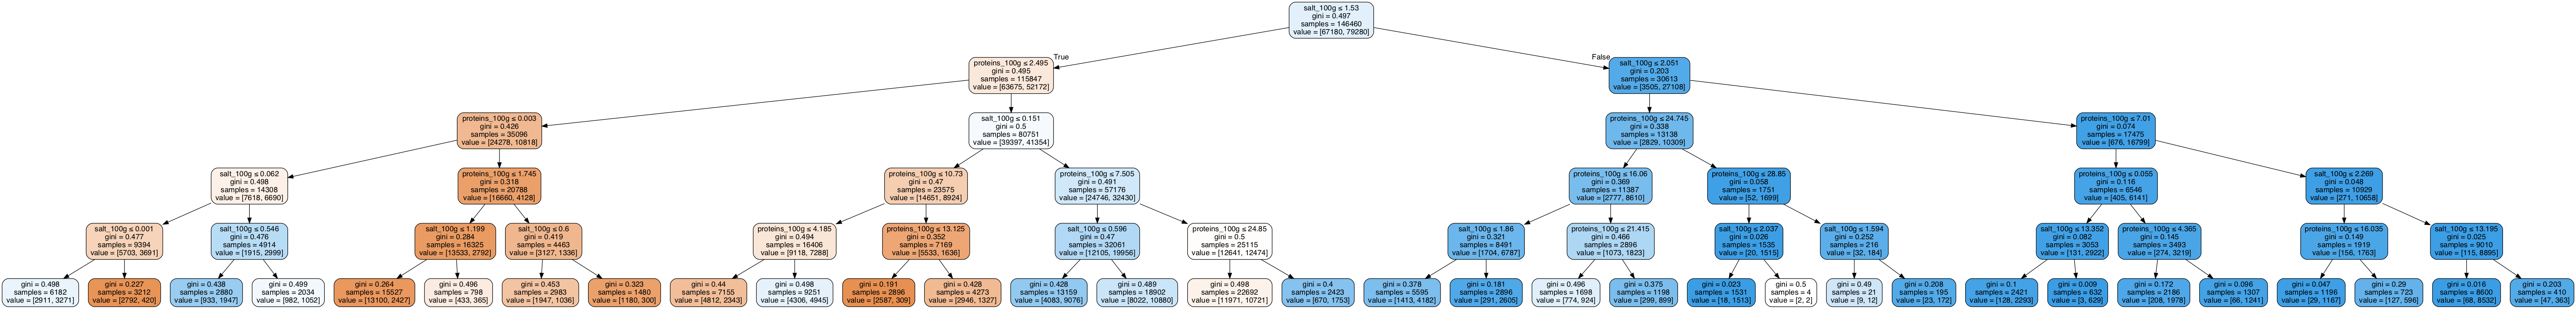

In [13]:
from sklearn.externals.six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())